In [1]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
import os
cwd= os.getcwd() # current working directory
path = os.path.join(cwd,'data')
def load_dataset():
    file_name=  os.path.join(path , 'train_catvnoncat.h5')
    train_dataset = h5py.File(file_name, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels

    file_name=  os.path.join(path , 'test_catvnoncat.h5')
    test_dataset = h5py.File(file_name, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = ['non-cat','cat']

    return X_train, Y_train, X_test, Y_test, classes

In [3]:
X_train,Y_train, X_test, Y_test, classes = load_dataset()

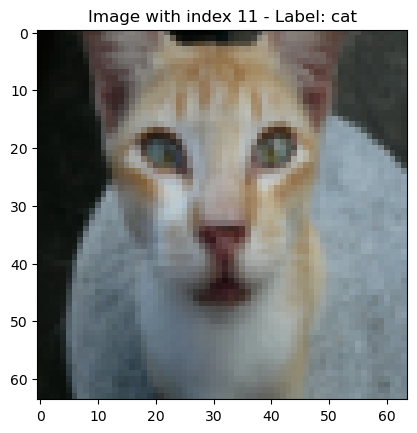

Labeled class: cat


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

index = 11
image_data = X_train[index]
label_index = Y_train[index]
class_label = classes[label_index]

image_reshaped = image_data.reshape(64, 64, 3)

plt.imshow(image_reshaped)
plt.title("Image with index " + str(index) + " - Label: " + class_label)
plt.show()

print("Labeled class:", class_label)


In [5]:
# Print the shapes of training and testing data
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_train.shape:", Y_train.shape)
print("Y_test.shape:", Y_test.shape)

# Extract dimensions and number of examples
m_train = X_train.shape[0]
m_test = X_test.shape[0]
num_px = X_train.shape[1]

# Print extracted information
print("\nNumber of training examples: m_train =", m_train)
print("Number of testing examples: m_test =", m_test)
print("Height/Width of each image: num_px =", num_px)
print("Each image is of size:", X_train.shape[1:])


X_train.shape: (209, 64, 64, 3)
X_test.shape: (50, 64, 64, 3)
Y_train.shape: (209,)
Y_test.shape: (50,)

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


In [6]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
Y_train = Y_train.reshape(1, Y_train.shape[0])
Y_test = Y_test.reshape(1, Y_test.shape[0])

print("X_train_flatten shape:", X_train_flatten.shape)
print("Y_train shape:", Y_train.shape)
print("X_test_flatten shape:", X_test_flatten.shape)
print("Y_test shape:", Y_test.shape)

X_train_flatten shape: (12288, 209)
Y_train shape: (1, 209)
X_test_flatten shape: (12288, 50)
Y_test shape: (1, 50)


In [7]:
X_train_scaled = X_train_flatten/255.
X_test_scaled = X_test_flatten/255.

In [8]:
def initialize_parameters(layer_dims):
    """
    layer_dims - list containing the dimensions of each layer in our network including input layer e.g. [12288,7,1]
    Returns: dictionary with keys "W" and "b" and their values are dicts with keys corresponding to layers numbers.
        for 'W' - value for every layer is weight matrix of shape (layer_dims[l], layer_dims[l-1])
        for 'b' - bias vector of shape (layer_dims[l], 1)
    """    
    np.random.seed(1)
    parameters = {'W':{}, 'b':{}}

    # Implement initialization using np.random.randn to match expected result
    W = {key:np.random.randn(layer_dims[key], layer_dims[key-1]) / np.sqrt(layer_dims[key-1]) for key in range(1, len(layer_dims))}
    b = {key:np.zeros((layer_dims[key], 1)) for key in range(1, len(layer_dims))}
    parameters = {'W':W, 'b':b}   
    return parameters

In [9]:
# check the initialize_parameters()
layer_dims= [2,3,5,1] 
params = initialize_parameters(layer_dims)
for l in range(1,len(layer_dims)):
    print ('W[{0}] =\n{1}\nb[{0}] =\n{2}\n'.format(l, params['W'][l], params['b'][l] ))

W[1] =
[[ 1.14858562 -0.43257711]
 [-0.37347383 -0.75870339]
 [ 0.6119356  -1.62743362]]
b[1] =
[[0.]
 [0.]
 [0.]]

W[2] =
[[ 1.00736754 -0.43948301  0.18419731]
 [-0.14397405  0.84414841 -1.18942279]
 [-0.18614766 -0.22173389  0.65458209]
 [-0.63502252 -0.09955147 -0.50683179]
 [ 0.02437212  0.33648852 -0.63544278]]
b[2] =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

W[3] =
[[ 0.51193601  0.40320363  0.2247223   0.40287503 -0.30577239]]
b[3] =
[[0.]]



In [10]:
def forward_propagation_step(A_prev, W, b, activation):
    """
    A_prev - activations from previous layer: (size of previous layer, number of examples)
    W - weights matrix: array of shape (size of current layer, size of previous layer)
    b - bias vector, array of shape (size of the current layer, 1)
    activation - text string "sigmoid" or "relu"

    Returns:
    A -  post-activation value 
    cache - tuple containing W, b, A_prev, Z stored for computing the backward pass
    """
    
    Z = W @ A_prev + b
    
    if activation == "sigmoid":
        A= sigmoid(Z)
        
    elif activation == "relu":
        A = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))

    cache = (W, b, A_prev, Z) # used at backward propagation. Note: b looks as need just to check the shape of dJ_db
    return A, cache


def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

In [11]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    # (≈ 2 lines of code)
    # logprobs = ...
    # cost = ...
    # YOUR CODE STARTS HERE
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - 1/m * np.sum(logprobs) 
    # YOUR CODE ENDS HERE
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [12]:
def init_backward_propagation(Y, A_last):
    dL_dA_last =  - (np.divide(Y, A_last) - np.divide(1 - Y, 1 - A_last))
    return dL_dA_last

In [13]:
def backward_propagation_step(dL_dA, cache, activation):
    """
    dL_dA - activation gradient for current layer l
    cache - (W, b, A_prev, Z) stored for current layer  l
    activation - string: "sigmoid" or "relu"
    
    Returns:
    dL_dA_prev - Gradient activation of the previous layer l-1, same shape as A_prev
    dL_dW - Gradient of W current layer l, same shape as W
    dL_db - Gradient of b (current layer l), same shape as b
    """
    W, b, A_prev, Z = cache 

    # backward activation part:
    if activation == "relu":
        dg_dz = relu_backward(Z)
    elif activation == "sigmoid":
        dg_dz = sigmoid_backward(Z)
        
    assert (dL_dA.shape == dg_dz.shape)
    dL_dZ = dL_dA * dg_dz

    # backward linear part:
    m = A_prev.shape[1]
    dL_dW = 1/m * dL_dZ @ A_prev.T
    dL_db = 1/m * np.sum(dL_dZ, axis=1, keepdims=True)
    dL_dA_prev = W.T @ dL_dZ

    assert (dL_dA_prev.shape == A_prev.shape)
    assert (dL_dW.shape == W.shape)
    assert (dL_db.shape == b.shape)

    return dL_dA_prev, dL_dW, dL_db
        

def relu_backward(Z):
    dg_dz = np.where(Z > 0, 1, 0)
    assert (dg_dz.shape == Z.shape)    
    return dg_dz



def sigmoid_backward(Z):

    dg_dz = sigmoid(Z)*(1-sigmoid(Z))
    assert (dg_dz.shape == Z.shape)    
    return dg_dz

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters due to gradient descent rule 
    parameters - dictionary with keys 'W' and 'b' each is dict with keys of layer numbers 
    grads - dictionary with keys 'W' and 'b' each is dict with keys of layer numbers 
   
    Returns: updated parameters the same shape as input parameters 
    """
   
    L = len(parameters['W']) # number of layers in the neural network
    # Update values for each parameter
    for l in range(1, L+1):
        parameters['W'][l] = parameters['W'][l] - learning_rate * grads['W'][l]
        parameters['b'][l] = parameters['b'][l] - learning_rate * grads['b'][l]
    
    return parameters

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    '''
    X - input layer of shape (input size, number of examples)
    Y - output layer of shape (1,m)
    layers_dims - list of layers dims including input layer 
    '''
  
    np.random.seed(1)
    grads = {'W':{}, 'b':{}}
    costs = []   # track the cost
    m = X.shape[1] # number of examples

    # Initialize parameters 
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        A1, cache1 = forward_propagation_step(X, parameters['W'][1], parameters['b'][1], activation='relu')
        A2, cache2 = forward_propagation_step(A1, parameters['W'][2], parameters['b'][2], activation='sigmoid')
        # Compute cost        
        cost = compute_cost(A2, Y)

        # Initialize backward propagation        
        dL_dA2 = init_backward_propagation(Y, A2)

        # Backward propagation.
        dL_dA1, grads['W'][2], grads['b'][2] = backward_propagation_step(dL_dA2, cache2, activation='sigmoid')
        _, grads['W'][1], grads['b'][1] = backward_propagation_step(dL_dA1, cache1, activation='relu')
        
       
        # Update parameters    
        parameters =  update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))

    
    return parameters

Cost after iteration 0: 0.6950464961800915
Cost after iteration 100: 0.6195808854384666
Cost after iteration 200: 0.5865026104533535
Cost after iteration 300: 0.5467810398248232
Cost after iteration 400: 0.49825722524914073
Cost after iteration 500: 0.45657385324276334
Cost after iteration 600: 0.4094471539583378
Cost after iteration 700: 0.3631730375845947
Cost after iteration 800: 0.3286113109883101
Cost after iteration 900: 0.29718068617894683
Cost after iteration 1000: 0.26900893277175103
Cost after iteration 1100: 0.24464399315834634
Cost after iteration 1200: 0.22384078814076205
Cost after iteration 1300: 0.20652180532903278
Cost after iteration 1400: 0.18938381861610273
Cost after iteration 1500: 0.17501499357058228
Cost after iteration 1600: 0.16159871226192452
Cost after iteration 1700: 0.1474534342625884
Cost after iteration 1800: 0.1347821561201472
Cost after iteration 1900: 0.12313379621287832
Cost after iteration 2000: 0.11228120642500024
Cost after iteration 2100: 0.10296

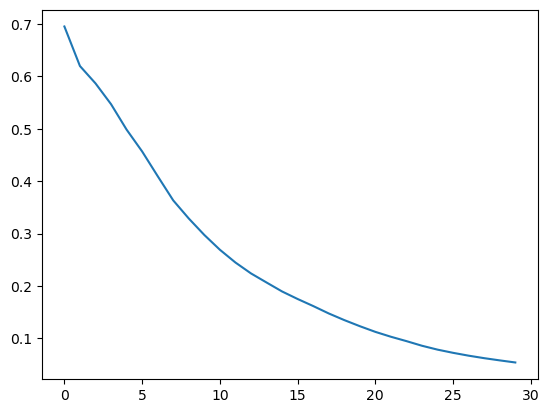

In [16]:

n_x = X_train_scaled.shape[0]
n_h= 7 
n_y = Y_train.shape[0]
layers_dims = [n_x, n_h, n_y]

parameters = two_layer_model(
    X_train_scaled, Y_train, layers_dims, learning_rate = 0.003, num_iterations = 3000, print_cost=True)

In [17]:
def forward_propagation_whole_process(X, parameters):
    """
    [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID
    X - data, array of shape (input size, number of examples)
    parameters - initialized parameters foreach of 'W' and 'b' keas values have keys 1,2,...L 
    
    Returns:
    A_last - last activation value (y_pred)
    caches - dict of caches containing every cache of forward propagation indexed from 0 to L-1
    """

    caches = {}
    A = X
    
    L = len(parameters['W']) # number of layers in the neural network

    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = forward_propagation_step(A_prev, parameters['W'][l], parameters['b'][l], activation='relu')
        caches[l] = cache

    
    #LINEAR -> SIGMOID
    A_last, cache = forward_propagation_step(A, parameters['W'][L], parameters['b'][L], activation='sigmoid')
    caches[L] = cache

    assert(A_last.shape == (1, X.shape[1])) # (1,m) 
            
    return A_last, caches

In [18]:
def backward_propagation_whole_process(A_last, Y, caches):
    """
    backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID 
    A_last - probability vector, output(y_pred) of the forward propagation 
    Y - true labels (0 if non-cat, 1 if cat)
    caches - dict of caches for each layer that contains (W, b, A, Z)
    Returns: grads - of keys 'W' and 'b' each containing the  dictionaries of keys 1..L  
    """
    dL_dA= {}
    dL_dW = {}
    dL_db= {}
    
    L = len(caches) # the number of layers
    m = A_last.shape[1] # number of samples
    Y = Y.reshape(A_last.shape) # make sure Y is the same shape as A_last(y_pred)
    
    # Initialize the backpropagation    
    dL_dA[L] = init_backward_propagation(Y, A_last)

    # layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L]
    dL_dA[L-1], dL_dW[L], dL_db[L] = backward_propagation_step(dL_dA[L], current_cache, activation='sigmoid')

    # Loop from l=L-2 to l=0
    for l in reversed(range(1,L)): #  starts with L-1 ends with 1 
        # l-th layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dL_dA[l-1], dL_dW[l], dL_db[l] = backward_propagation_step(dL_dA[l], current_cache, activation='relu')
        
    grads= {'W':dL_dW, 'b':dL_db}
    
    return grads

In [19]:
def model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, verbose = False):
    """
    X - data, array of shape (number of examples, num_px * num_px * 3)
    Y - true label vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims - list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate - learning rate of the gradient descent update rule
    num_iterations - number of iterations of the optimization loop
    verbose - if True, it prints the cost every 100 steps
    
    Returns:
    parameters - parameters learnt by the model. They can then be used to predict.
    """
    print ('Training {}-layers neural network with layers dimensions: {}'.format (len(layers_dims)-1, layers_dims))
    np.random.seed(1)
    costs = [] # to track of cost
            
    parameters = initialize_parameters(layers_dims)
        
    # Loop (gradient descent)
    for i in range(num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        A_last, caches = forward_propagation_whole_process(X, parameters)

        # Compute cost
        cost = compute_cost(A_last, Y)

        # Backward propagation.
        grads = backward_propagation_whole_process(A_last, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
       
                
        # Print the cost every 100 training example
        if verbose and i % 100 == 0:
            print ("Cost after iteration {}: {}".format(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    
   
    return parameters

Training 2-layers neural network with layers dimensions: [12288, 7, 1]
Cost after iteration 0: 0.6950464961800915
Cost after iteration 100: 0.6195808854384666
Cost after iteration 200: 0.5865026104533535
Cost after iteration 300: 0.5467810398248232
Cost after iteration 400: 0.49825722524914073
Cost after iteration 500: 0.45657385324276334
Cost after iteration 600: 0.4094471539583378
Cost after iteration 700: 0.3631730375845947
Cost after iteration 800: 0.3286113109883101
Cost after iteration 900: 0.29718068617894683
Cost after iteration 1000: 0.26900893277175103
Cost after iteration 1100: 0.24464399315834634
Cost after iteration 1200: 0.22384078814076205
Cost after iteration 1300: 0.20652180532903278
Cost after iteration 1400: 0.18938381861610273
Cost after iteration 1500: 0.17501499357058228
Cost after iteration 1600: 0.16159871226192452
Cost after iteration 1700: 0.1474534342625884
Cost after iteration 1800: 0.1347821561201472
Cost after iteration 1900: 0.12313379621287832
Cost after

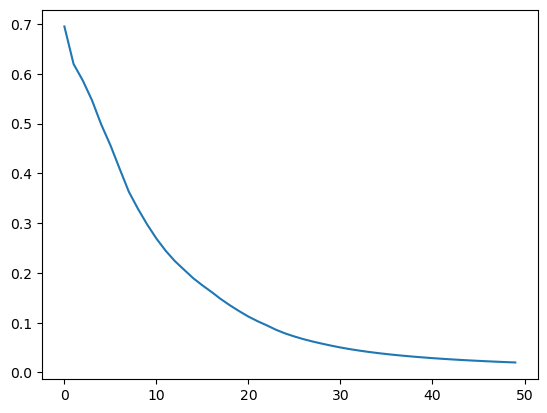

In [20]:
n_x = X_train_scaled.shape[0]
n_h= 7 
n_y = Y_train.shape[0]
layers_dims = [n_x, n_h, n_y]

parameters = model(
    X_train_scaled, Y_train, layers_dims, num_iterations = 5000, verbose = True, 
    learning_rate = 0.003) 

Training 4-layers neural network with layers dimensions: [12288, 20, 7, 5, 1]
Cost after iteration 0: 0.7717493284237688
Cost after iteration 100: 0.6720534400822913
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.567047326836611
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268134
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005211
Cost after

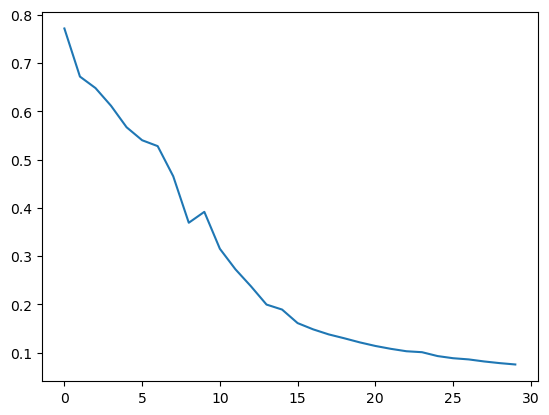

In [21]:

n_x = X_train_flatten.shape[0]
n_y = Y_train.shape[0]
layers_dims = [n_x,20,7,5,n_y]

parameters = model(
    X_train_scaled, Y_train, layers_dims, num_iterations = 3000, verbose = True, 
    learning_rate = 0.0075) 

In [22]:
def predict(X, parameters):
    """        
    X - array set to predict 
    parameters - parameters of the trained model
    Returns:
    Y_pred - predictions for the given dataset X
    """

    # Forward propagation
    A_last, _ = forward_propagation_whole_process(X, parameters)
    Y_pred= (A_last > 0.5).astype(int)
    
    return Y_pred

In [23]:
Y_pred_train = predict (X_train_scaled, parameters)
Y_pred_test = predict (X_test_scaled, parameters)

print ('Train accuracy = {:.3%}'.format(np.mean (Y_pred_train == Y_train)))
print ('Test accuracy = {:.3%}'.format(np.mean (Y_pred_test == Y_test)))

Train accuracy = 99.043%
Test accuracy = 82.000%
